# 🏥 Epileptic Seizure Recognition

Epilepsy is a neurological disorder characterized by a predisposition to the onset of epileptic (or comitial) seizures. It is one of the most frequent neurological diseases, with a prevalence of about 1 percent (500,000 patients) in Italy.

The electroencephalogram makes it possible to investigate brain function, record electrical activity, and highlight certain abnormalities, called epileptiforms, which, however, cannot always be classified as epileptic during visualization.

For this reason, Machine Learning can positively help the classification of electrical activities: starting from the analysis of different electrical activities that have already been classified in the past, ML offers the possibility of unearthing epileptogenic fragments, even those that by pure human analysis in the past have not been classified as abnormal.

This project aims to test different Machine Learning models and analyze the results; in addition, it is possible, via a web page, to insert new fragments of electrical activity to visualize their classification (epilepsy or not) by choosing a ML model.

## 🚿 Data import and cleaning

Since the first column (i.e., the one showing the exam number from which it was obtained) is not needed, it can be removed from the dataset.

In [395]:
import pandas as pd

# Loading
data = pd.read_csv('Dataset/data.csv')

# Removing first column (not useful)
data.drop('Unnamed', axis=1, inplace=True)

## 👀 Data Observation

The original data from which the dataset was obtained consisted of 500 different EEG recordings, each of which contained 4097 data points and lasts about 23.6 seconds; each recording was divided into 23 fragments (each fragment then lasts a little more than a second), resulting in 11500 rows of data. The distance between two points therefore is ***23.6 sec ÷ 4096 = 0.0058 sec***.

Each row is suffixed into 5 types, i.e., the y column contains a value between {1, 2, 3, 4, 5}:
- y = 5: recording with eyes open;
- y = 4: recording with eyes closed;
- y = 3: recording in cancer patients of electrical activity in non-cancerous parts of the brain;
- y = 2: recording in tumor patients of electrical activities in tumor parts of the brain;
- y = 1: epileptogenic rerecording.

### y diffences
Let's look at the general difference between EEG recordings of type {1, 2, 3, 4, 5}:

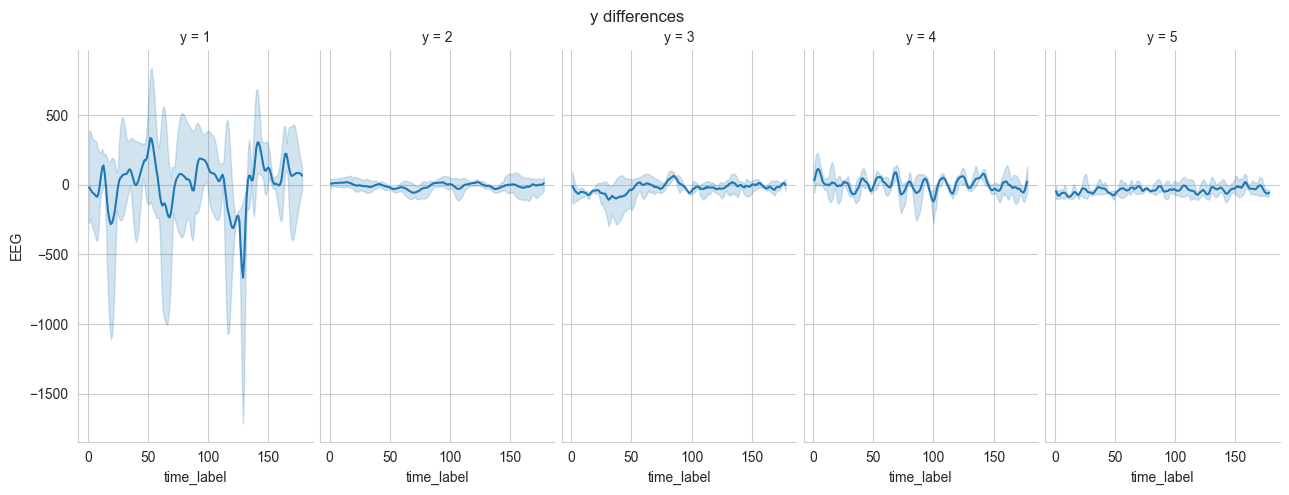

In [396]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
    
n = 3
data_y_1 = data[data['y'] == 1][:n]
data_y_2 = data[data['y'] == 2][:n]
data_y_3 = data[data['y'] == 3][:n]
data_y_4 = data[data['y'] == 4][:n]
data_y_5 = data[data['y'] == 5][:n]
samples_to_show = pd.concat([data_y_1, data_y_2, data_y_3, data_y_4, data_y_5], axis=0, ignore_index=True)

# Creating a dataframe with one row for each value of X
df_splitted_seizure_short = (samples_to_show
                .melt(id_vars=['y'], var_name='time_label', value_name='EEG', ignore_index=False)
                .reset_index()
                .rename(columns={'index': 'id'})
            )

# Getting time_index column from time_label
df_splitted_seizure_short['time_label'] = (df_splitted_seizure_short['time_label'].str.translate(str.maketrans('', '', 'X')).astype(int))

# Creating and showing the graph
g = sns.relplot(
    data=df_splitted_seizure_short,
    kind='line',
    x='time_label',
    y='EEG',
    col='y'
)
g.fig.subplots_adjust(top=.9, left=.07)
g.fig.suptitle("y differences")
g.fig.set_size_inches(13, 5)
plt.legend([], [], frameon=False)
plt.show()

It is possible to guess that epileptic EEGs manifest larger electrical activities in height (electrical potential) and width (frequency).

### y-values number
For each value of y is contained exactly 2300 rows:

Text(0.5, 0.98, 'Number of rows for each value of y')

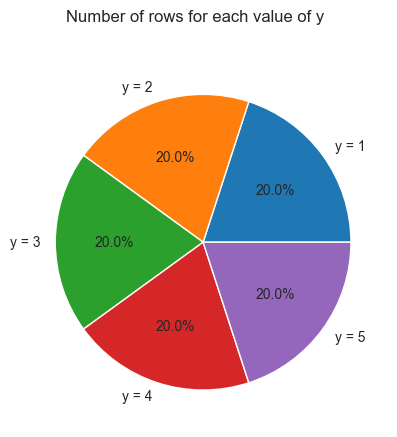

In [397]:
# Checking the number of rows for each value of y
data_y_1 = data[data['y'] == 1]
data_y_2 = data[data['y'] == 2]
data_y_3 = data[data['y'] == 3]
data_y_4 = data[data['y'] == 4]
data_y_5 = data[data['y'] == 5]


labels = 'y = 1', 'y = 2', 'y = 3', 'y = 4', 'y = 5'
sizes = [len(data_y_1.index), len(data_y_2.index), len(data_y_3.index), len(data_y_4.index), len(data_y_5.index)]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
fig.suptitle("Number of rows for each value of y")

## 🔧 Correction of y-values

Since the epileptogenic rows are only those with y equal to 1, we modify the values of y:
- if y ∈ {2, 3, 4, 5}, it will be transformed into y = 0 (of y = 'Non-epileptic'), i.e., non-epileptogenic rows
- if y = 1 it will remain so (or y = 'Epileptic'), i.e., epileptogenic rows

In [398]:
import numpy as np

data['y'] = np.where(data['y'] == 1, 1, 0)
data_exploratory = data.copy()
data_exploratory['y'] = np.where(data_exploratory['y'] == 1, 'Epileptic', 'Non-epileptic')

## 📉 Exploratory Data Analysis: examples

### Heatmap

Text(0.5, 1.0, 'Heatmap')

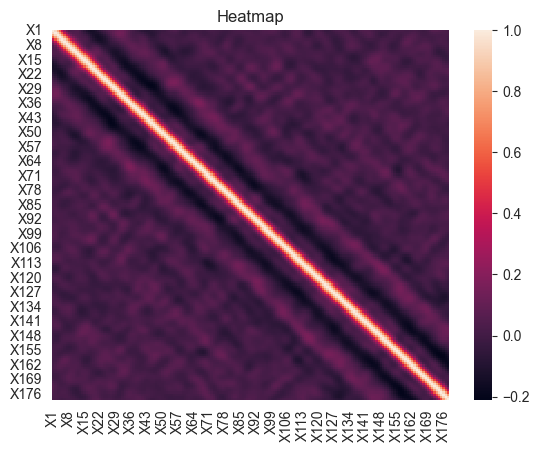

In [399]:
import seaborn as sns

# removing y values
heatmap_data = data_exploratory.iloc[:,0:178]

# creating heatmap
sns.heatmap(heatmap_data.corr())
plt.title("Heatmap")

### EEG potential (*μV*): ***min, max & Standard Deviation***

To analyze how the EEGs used extend, and to visualize the difference between epileptic and nonepileptic electrical activity, relational, distribution and categorical plot can be created regarding the ***minimum/maximum/mean*** or ***Standard Deviation*** potential and frequence of neurological beats. 

Let's analyze the potential of EEG records; now we start by calculating the minimum and maximum values:

In [400]:
# adding min, max and id columns
df_potential_min_max = pd.DataFrame()
df_potential_min_max['Min'] = data_exploratory.min(axis=1, numeric_only=True)
df_potential_min_max['Max'] = data_exploratory.max(axis=1, numeric_only=True)
df_potential_min_max['id'] = data_exploratory.index + 1
df_potential_min_max['y'] = data_exploratory['y']
df_potential_min_max = (df_potential_min_max.melt(id_vars=['id', 'y'], var_name='Value type', value_name='value', ignore_index=True))

We can try to analyze it with ***categorical plotes***, ***distribution plot*** with ***Kernel Density Estimation*** and ***relational plot***:

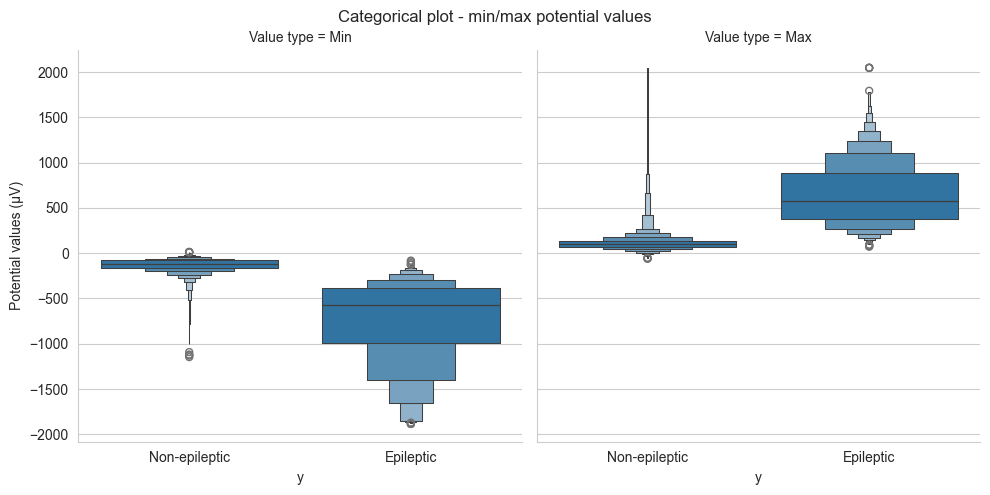

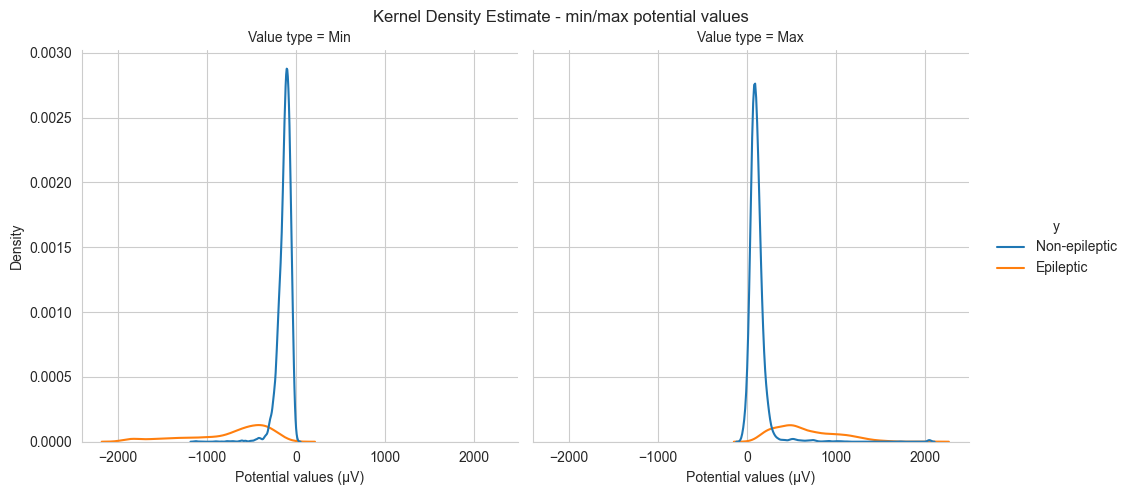

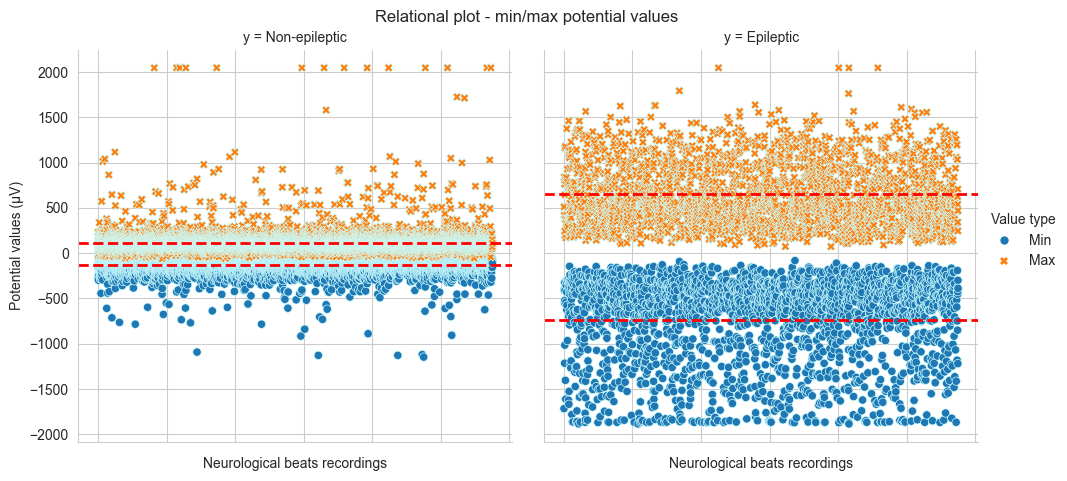

In [401]:
# categorical plot
cat = sns.catplot(
    data=df_potential_min_max,
    kind='boxen',
    x='y',
    y='value',
    col='Value type'
)
cat.set_ylabels('Potential values (μV)', clear_inner=False)
cat.fig.subplots_adjust(top=.9)
cat.fig.suptitle("Categorical plot - min/max potential values")


# distribution plot with Kernel Density Estimation
dist = sns.displot(
    data=df_potential_min_max,
    kind='kde',
    x='value',
    hue='y',
    col='Value type'
)
dist.fig.subplots_adjust(top=.9)
dist.fig.suptitle("Kernel Density Estimate - min/max potential values")
dist.set_xlabels('Potential values (μV)', clear_inner=False)


# relational plot
rel = sns.relplot(
    data=df_potential_min_max,
    x='id',
    y='value',
    col='y',
    hue='Value type',
    style='Value type',
    edgecolor='#CCFFFF'
)
rel.set_xlabels('Neurological beats recordings', clear_inner=False)
rel.set_ylabels('Potential values (μV)', clear_inner=False)
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle("Relational plot - min/max potential values")
rel.set(xticklabels=[])

axes = rel.axes.flat[0]
axes.axhline(df_potential_min_max[(df_potential_min_max['y'] == 'Non-epileptic') & (df_potential_min_max['Value type'] == 'Min')]['value'].mean(), ls='--', linewidth=2, color='red')
axes.axhline(df_potential_min_max[(df_potential_min_max['y'] == 'Non-epileptic') & (df_potential_min_max['Value type'] == 'Max')]['value'].mean(), ls='--', linewidth=2, color='red')
axes = rel.axes.flat[1]
axes.axhline(df_potential_min_max[(df_potential_min_max['y'] == 'Epileptic') & (df_potential_min_max['Value type'] == 'Min')]['value'].mean(), ls='--', linewidth=2, color='red')
axes.axhline(df_potential_min_max[(df_potential_min_max['y'] == 'Epileptic') & (df_potential_min_max['Value type'] == 'Max')]['value'].mean(), ls='--', linewidth=2, color='red')

Now let's try to analyze the difference between epileptic and non-epileptic EEG based on the Standard Deviation of the potential:

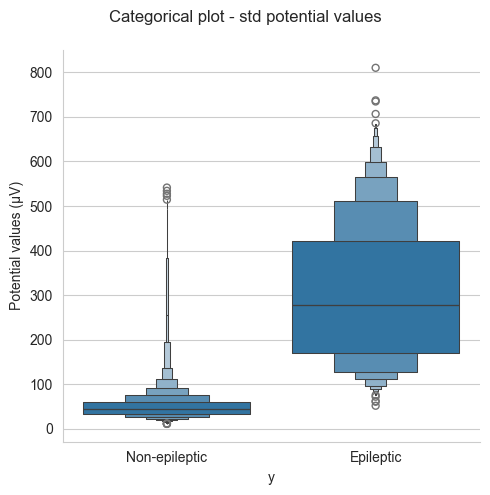

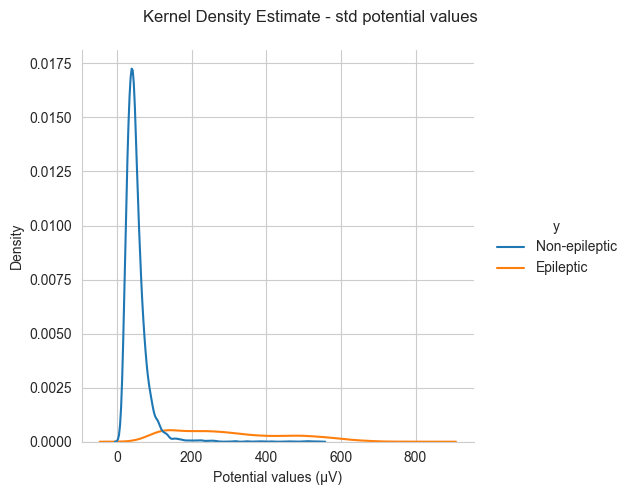

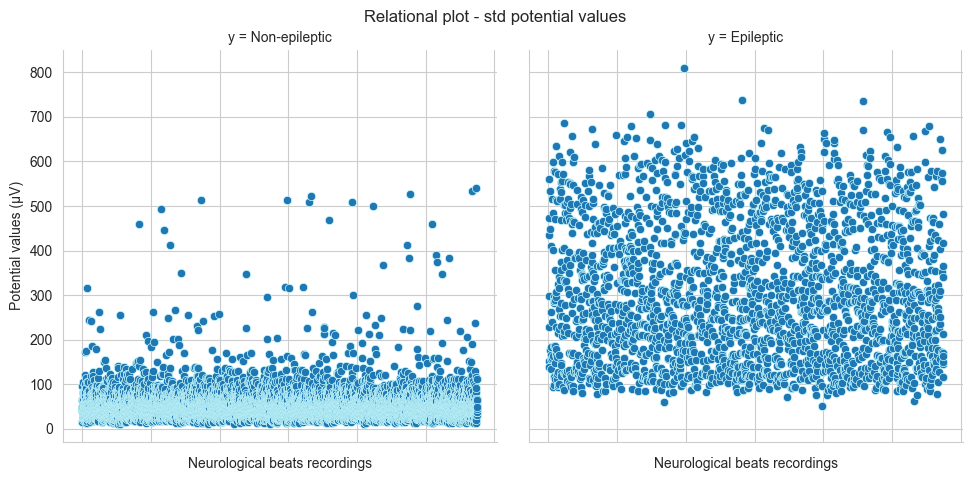

In [402]:
# calculating Standard Deviation
df_potential_std = data_exploratory.iloc[:, 0:178]
df_potential_std = df_potential_std.std(axis=1).reset_index()
df_potential_std['y'] = data_exploratory['y']
df_potential_std['id'] = df_potential_std.index + 1


# categorical plot
cat = sns.catplot(
    data=df_potential_std,
    kind='boxen',
    x='y',
    y=0
)
cat.set_ylabels('Potential values (μV)', clear_inner=False)
cat.fig.subplots_adjust(top=.9)
cat.fig.suptitle("Categorical plot - std potential values")


# distribution plot with Kernel Density Estimation
dist = sns.displot(
    data=df_potential_std,
    kind='kde',
    x=0,
    hue='y',
)
dist.fig.subplots_adjust(top=.9)
dist.fig.suptitle("Kernel Density Estimate - std potential values")
dist.set_xlabels('Potential values (μV)', clear_inner=False)


# relational plot
rel = sns.relplot(
    data=df_potential_std,
    x='id',
    y=0,
    col='y',
    edgecolor='#CCFFFF'
)
rel.set_xlabels('Neurological beats recordings', clear_inner=False)
rel.set_ylabels('Potential values (μV)', clear_inner=False)
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle("Relational plot - std potential values")
rel.set(xticklabels=[])

It is evident how epileptic seizures are manifested in much larger EEGs from the point of view of electrical potential.

### EEG frequency (*Hz*)

Let us now analyze the frequenca of EEG samples. The celebral waves are divided according to frequenca into:
- delta rhythm: 0.5-4 Hz (average amplitude of 150 µV);
- theta rhythm: 4-7.5 Hz (average amplitude of 75 mV);
- alpha rhythm: 8-13 Hz (average amplitude of 30 mV);
- theta-sigma rhythm: 12-14 Hz (average amplitude of 5-50 µV);
- beta rhythm: 13.5-30 Hz (average amplitude of 19 mV).

For frequency calculation, it is necessary to find the maximum or minimum values of the sine wave-like trend. Since choosing the analysis by the minimum or maximum values does not result in any difference, let's try to perform it on the maximum values:

In [403]:
df_frequence_prepare = data_exploratory.iloc[:, 0:178]
df_frequence_prepare['max_number'] = 0
for count in range(2,178):
    df_frequence_prepare.loc[(data_exploratory["X"+str(count-1)] < data_exploratory["X"+str(count)]) &
                             (data_exploratory["X"+str(count)] > data_exploratory["X"+str(count+1)]),
                    "max_number"] = df_frequence_prepare['max_number'] + 1

We now search for the maximum and minimum values for each EEG line and convert the values to seconds (i.e., knowing that each line contains the values recorded in one second, we divide the values obtained by 178)

Let's now try to compare the frequency of epileptic and nonepileptic EEGs; we visualize it in categorical plot, distribution plot, and relational plot:

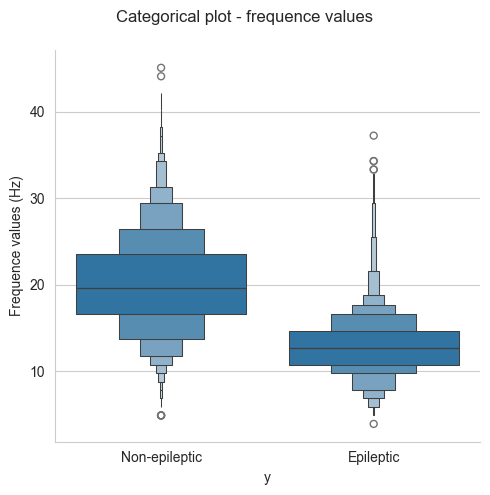

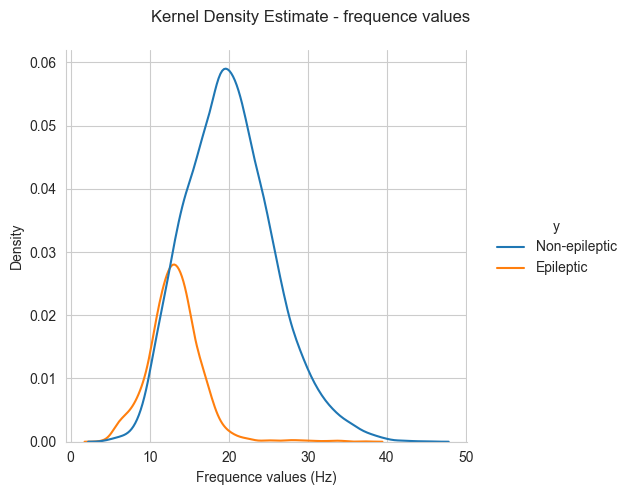

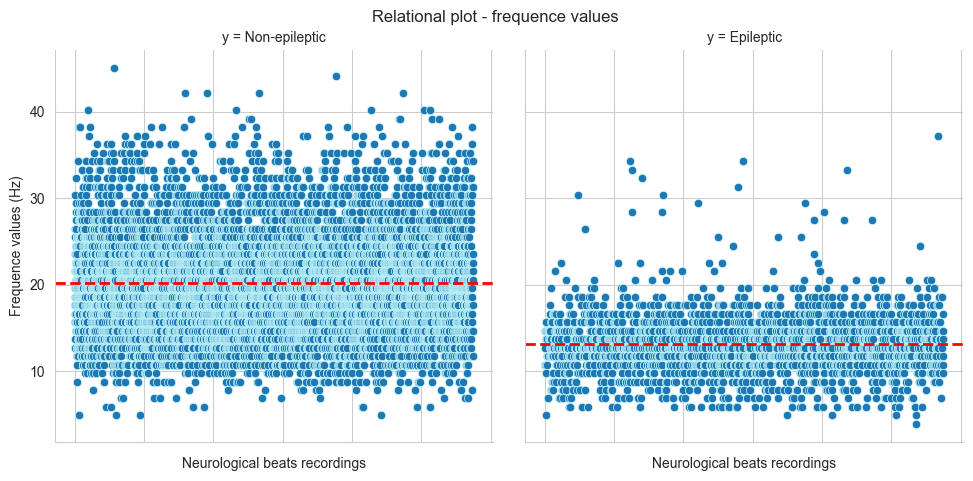

In [404]:
# frequence calculation
df_frequence_mean = pd.DataFrame()
df_frequence_mean['Freq'] = df_frequence_prepare['max_number']/1.02
df_frequence_mean['id'] = data_exploratory.index + 1
df_frequence_mean['y'] = data_exploratory['y']


# categorical plot
cat = sns.catplot(
    data=df_frequence_mean,
    kind='boxen',
    x='y',
    y='Freq'
)
cat.set_ylabels('Frequence values (Hz)', clear_inner=False)
cat.fig.subplots_adjust(top=.9)
cat.fig.suptitle("Categorical plot - frequence values")


# distribution plot with Kernel Density Estimation
dist = sns.displot(
    data=df_frequence_mean,
    kind='kde',
    x='Freq',
    hue='y',
)
dist.fig.subplots_adjust(top=.9)
dist.fig.suptitle("Kernel Density Estimate - frequence values")
dist.set_xlabels('Frequence values (Hz)', clear_inner=False)


# relational plot
ret = sns.relplot(
    data=df_frequence_mean,
    x='id',
    y='Freq',
    col='y',
    edgecolor='#CCFFFF'
)
ret.set_xlabels('Neurological beats recordings', clear_inner=False)
ret.set_ylabels('Frequence values (Hz)', clear_inner=False)
ret.fig.subplots_adjust(top=.9)
ret.fig.suptitle("Relational plot - frequence values")
ret.set(xticklabels=[])

axes = ret.axes.flat[0]
axes.axhline(df_frequence_mean[(df_frequence_mean['y'] == 'Non-epileptic')]['Freq'].mean(), ls='--', linewidth=2, color='red')
axes = ret.axes.flat[1]
axes.axhline(df_frequence_mean[(df_frequence_mean['y'] == 'Epileptic')]['Freq'].mean(), ls='--', linewidth=2, color='red')

As noted by the graphs regarding the width of the periods, we can also observe this more clearly from the frequency representations: the rhythm is far less in the case of epileptic EEGs.

## Ⓜ️ Machine Learning Algorithms: example with Neural Network


Several Machine Learning algorithms have been carried out, including
- Decision Tree Classifier;
- Decision Tree Regression;
- Extra Tree Classifier;
- Extra Tree Regression;
- Gaussian Naive Bayes;
- k-nearest Neighbors;
- Multi-layout Perception Classifier;
- Neural Network;
- Support Vector Classification.

Let's visualize ***Neural Network***.

### Preprocessing

First, it is necessary to divide the values of each row of the dataset into:
- ***X***, ***y***: ***X*** corresponds to the EEG data, ***y*** corresponds to the type (epileptic or non-epileptic)
- ***X_train***, ***y_train***, ***X_test***, ***y_test***: ***_train*** corresponds to 80% of the rows, while ***_test*** corresponds to 20%.

In [405]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# dividing EEG data and epileptic/non-epileptic typology
X = data.iloc[:,0:178].values
y = data.iloc[:,178].values

# dividing in training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Training & test: a bit long 😉

Now treaning can be launched! Let's use GridSearchCV to run the training with different settings and figure out which one allows better prediction:

In [406]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


#################################
####### Training and Test #######
#################################
#preparing
grid = {
    'hidden_layer_sizes': [(20,), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.05],
    'max_iter': [1000]
}
cross_val = GridSearchCV(MLPClassifier(), grid, cv = 7, n_jobs=2, verbose=10)

# training
cross_val.fit(X_train, y_train)

# test
Y_hat_test = cross_val.predict(X_test)

# printing results
print('Tuned hpyerparameters (best parameters): ', cross_val.best_params_)
print('Estimator that was chosen by the search: ', cross_val.best_estimator_)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
Tuned hpyerparameters (best parameters):  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000, 'solver': 'sgd'}
Estimator that was chosen by the search:  MLPClassifier(alpha=0.05, hidden_layer_sizes=(100, 100), max_iter=1000,
              solver='sgd')


### Evaluation

Now training and testing is over! Let's look at a generic classification report and scores to see if the chosen ML algorithm is suitable:

In [407]:
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score, jaccard_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import classification_report


# classification report
print('Model classification report with GridSearcg CV: \n', classification_report(y_test, Y_hat_test))

# evaluations
accuracy_score_val = accuracy_score(y_test, Y_hat_test)
f1_score_val = f1_score(y_test, Y_hat_test)
cohen_score_val = cohen_kappa_score(y_test, Y_hat_test)
jaccard_score_val = jaccard_score(y_test, Y_hat_test)
precision_score_val = precision_score(y_test, Y_hat_test)
recall_score_val = recall_score(y_test, Y_hat_test)
balanced_score_val = balanced_accuracy_score(y_test, Y_hat_test)
eval = ['Accuracy:', 'F1:', 'Cohen Kappa:', 'Jaccard:', 'Precision:', 'Recall:', 'Balanced Accuracy:']
score = [accuracy_score_val, f1_score_val, cohen_score_val, jaccard_score_val, precision_score_val, recall_score_val, balanced_score_val]
dict = {'Evaluation': eval, 'Score on the test set': score}
df = pd.DataFrame(dict)
df = df.style.background_gradient()
df

Model classification report with GridSearcg CV: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1821
           1       0.95      0.94      0.94       479

    accuracy                           0.98      2300
   macro avg       0.96      0.96      0.96      2300
weighted avg       0.98      0.98      0.98      2300



,Evaluation,Score on the test set
0,Accuracy:,0.975217
1,F1:,0.940189
2,Cohen Kappa:,0.924560
3,Jaccard:,0.887129
4,Precision:,0.945148
5,Recall:,0.935282
6,Balanced Accuracy:,0.960502


The test set scores are between 88% and 97%, so Neural Network is an excellent Machine Learning algorithm for classification of epileptic EEGs!

### Confusion matrix

To have a graphic proof of the evaluation just obtained, let's visualize a confusion matrix:

<Axes: >

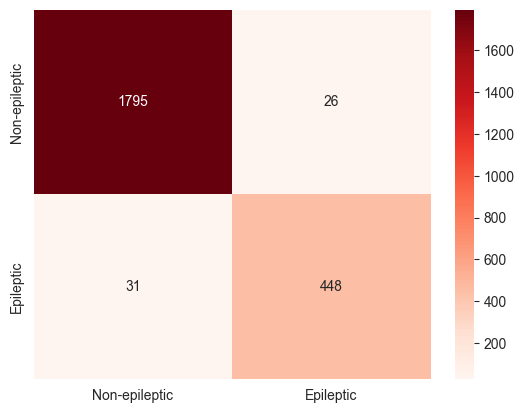

In [408]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, Y_hat_test)
fig, ax = plt.subplots()
sns.heatmap(cm, ax = ax, annot = True, cmap = plt.cm.Reds, fmt = 'd', xticklabels = ['Non-epileptic', 'Epileptic'], yticklabels = ['Non-epileptic', 'Epileptic'])

## ❓ PMML creation: example with Neural Network

### ❗Needs to downgrade SKLEARN to 1.2.2❗

If we want to use what we get from the ML algorithm, it is possible to use PMML (Predictive Model Markup Language), which is an open XML-based markup language designed to allow the description of predictive analysis models that can be shared among different systems and applications.

Having already run the ML algorithm with GridSearchCV we know which settings provide better results...but beware! ***sklearn2pmml*** does not yet accept the latest version of sklearn, for this duindi we have to downgrade it 😢

First we launch the Openscoring server:

In [409]:
import subprocess
import warnings
warnings.filterwarnings('ignore')


# starting Openscoring server
subprocess.Popen(["java", "-jar", "Server/lib/openscoring-server-executable-2.1.1.jar"])

<Popen: returncode: None args: ['java', '-jar', 'Server/lib/openscoring-serv...>

Then we run the ML algorithm with precise activation functions:

In [410]:
from sklearn.neural_network import MLPClassifier
from sklearn2pmml.pipeline import PMMLPipeline


# setting grid
grid_pmml = {
            'hidden_layer_sizes': (100, 100),
            'activation': 'tanh',
            'solver': 'sgd',
            'alpha': 0.0001,
            'max_iter': 1000
        }

# preparing
pipeline = PMMLPipeline([("classifier", MLPClassifier(**grid_pmml))])

# training
pipeline.fit(X, y)

PMMLPipeline(steps=[('classifier', MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100), max_iter=1000,
              solver='sgd'))])

Next we create the .pmml format from what was obtained through training and testing:

In [411]:
from sklearn2pmml import sklearn2pmml


# creating .pmml
sklearn2pmml(pipeline, "Server\\pmml\\NeuralNetwork.pmml")

Finally, we activate the Openscoring client in order to use the .pmml we just obtained:

In [412]:
# starting Openscoring with .pmml
subprocess.run(["powershell", "java -cp Server\\lib\\openscoring-client-executable-2.1.1.jar org.openscoring.client.Deployer --model http://localhost:8080/openscoring/model/NeuralNetwork --file Server\\pmml\\NeuralNetwork.pmml"], shell=True)       

CompletedProcess(args=['powershell', 'java -cp Server\\lib\\openscoring-client-executable-2.1.1.jar org.openscoring.client.Deployer --model http://localhost:8080/openscoring/model/NeuralNetwork --file Server\\pmml\\NeuralNetwork.pmml'], returncode=0)